In [1]:
import numpy as np
import pandas as pd
from numpy.random import shuffle
from numpy.random import randint
from random import choice
# %matplotlib widget
import matplotlib.pyplot as plt
import sys
import copy
import random
import math
import networkx as nx
import os

## General Class for Problem Solving

In [2]:
# Read gml file to get the topology, since the distance is not included, 
# the distance of each link in the graph is generated randomly. 
# Since we assume all the links are bidirectional, only bidirectional or undirectional gml file could be read properly. 
def read_graph_from_gml(file_name):
  gml_file = nx.read_gml(file_name)
  A = nx.adjacency_matrix(gml_file)
  t = A.toarray()
  for iy, ix in np.ndindex(t.shape):
      if t[iy, ix] == 1:
          t[iy, ix] = random.randint(1, 10)
  graph = np.maximum( t, t.transpose() )

  return graph

In [3]:
# Representing the graph using adjacent graph
class Graph(object):

    # Initialize the matrix
    def __init__(self, adj_matrix):
        self.adj_matrix = adj_matrix
        self.size = len(adj_matrix)

    # Add edges
    def add_edge(self, v1, v2, dist):
        if v1 == v2:
            print("Same vertex %d and %d" % (v1, v2))
        self.adj_matrix[v1][v2] = dist
        self.adj_matrix[v2][v1] = dist

    # Remove edges
    def remove_edge(self, v1, v2):
        if self.adj_matrix[v1][v2] == 0:
            print("No edge between %d and %d" % (v1, v2))
            return
        self.adj_matrix[v1][v2] = 0
        self.adj_matrix[v2][v1] = 0

    def __len__(self):
        return self.size


    # Print the matrix
    def print_matrix(self):
        print(np.matrix(self.adj_matrix))


In [4]:
# The postman that need to deliver packages. 
class Postman(object):
    
    def __init__(self, size=None, salary=0, speed_matrix=None):
      # speed[i][k]: speed on link i to k
      self.speed_matrix = self.gen_speed_matrix(size) if size != None else speed_matrix
      # time_matrix[i] = time to node_i
      self.time_matrix = []
      self.salary  = self.gen_salary() if salary == 0 else salary

    def set_time_matrix(self, time_matrix):
      self.time_matrix = time_matrix
    
    def gen_speed_matrix(self, size):
      speed_matrix = [[0 for i in range(size)] for j in range(size)]

      for i in range(size):
        for j in range(i, size):
          speed_matrix[i][j] = random.randint(1, 10)
          speed_matrix[j][i] = speed_matrix[i][j]
      return speed_matrix
    
    def gen_salary(self):
      return random.randint(1, 10)
    
    def to_dict(self):
      return {
          'speed_matrix': self.speed_matrix,
          'time_matrix': self.time_matrix,
          'salary': self.salary
      }

In [5]:
# def generate_postmen_and_demands():
#     for gml_file in os.listdir('sample_graph'):
#         adj_matrix = read_graph_from_gml('sample_graph/' + gml_file)
#         graph = Graph(adj_matrix)
#         size = len(graph)
#         postmen = []
#         demands = []
#         for i in range(int(size * 0.2)):
#             postmen.append(Postman(size=size))
#         for i in range(int(size * 3)):
#             demands.append(random.randint(0, size - 1))
#         with open('postmen/' + gml_file + '.txt', 'w') as f:
#             dict_postmen = {}
#             for idx, postman in enumerate(postmen):
#                 dict_postmen[idx] = postman.to_dict()
#             f.write(str(dict_postmen))
#         with open('demands/' + gml_file + '.txt', 'w') as f:
#             f.write(str(demands))
# generate_postmen_and_demands()

# Read the postmen and demands from the file.
def read_postmen_and_demands(gml_file):
    postmen = []
    with open('postmen/' + gml_file + '.txt', 'r') as f:
        dict_postmen = eval(f.read())
        for _, postman in dict_postmen.items():
            postmen.append(Postman(speed_matrix=postman['speed_matrix'], salary=postman['salary']))
    with open('demands/' + gml_file + '.txt', 'r') as f:
        demands = eval(f.read())
    return postmen, demands

In [6]:
class Chromosome(object):
  def __init__(self, assignment, finish_time, postmen_cost):
    self.assignment = assignment
    self.finish_time = finish_time
    self.postmen_cost = postmen_cost
    self.fitness = 0
  
  def __str__(self) -> str:
     return f'Assignment {self.assignment} would deliver all packages in {self.finish_time} minutes, with postmen_cost {self.postmen_cost}'

In [7]:
class Model(object):
  def __init__(self, graph, postmen, demands):
    self.graph = graph.adj_matrix
    self.num_node = len(graph.adj_matrix)
    self.postmen = postmen
    self.cost_matrixs = []
    self.demands = demands

    for postman in self.postmen:
      single_cost_matrix = np.divide(self.graph, postman.speed_matrix)
      self.cost_matrixs.append(single_cost_matrix)
      postman.set_time_matrix(self.dijkstra(0, single_cost_matrix))
  
  def printSolution(self, dist):
    print("Vertex \tDistance from Source")
    for node in range(self.num_node):
      print(node, "\t", dist[node])

  def minDistance(self, dist, sptSet):
  
    # Initialize minimum distance for next node
    min = sys.maxsize
    min_index = 0

    # Search not nearest vertex not in the
    # shortest path tree
    for u in range(self.num_node):
      if dist[u] < min and sptSet[u] == False:
        min = dist[u]
        min_index = u

    return min_index

  def dijkstra(self, src, graph):
  
    dist = [sys.maxsize] * self.num_node
    dist[src] = 0
    sptSet = [False] * self.num_node

    for cout in range(self.num_node):

      # Pick the minimum distance vertex from
      # the set of vertices not yet processed.
      # x is always equal to src in first iteration
      x = self.minDistance(dist, sptSet)

      # Put the minimum distance vertex in the
      # shortest path tree
      sptSet[x] = True

      # Update dist value of the adjacent vertices
      # of the picked vertex only if the current
      # distance is greater than new distance and
      # the vertex in not in the shortest path tree
      for y in range(self.num_node):
        if graph[x][y] > 0 and sptSet[y] == False and \
              dist[y] > dist[x] + graph[x][y]:
          dist[y] = dist[x] + graph[x][y]

    # self.printSolution(dist)
    return dist

  def gen_population(self, population_size):
    population = []
    for i in range(population_size):
        population.append(self.gen_random_route())
    return population
  
  def gen_random_route(self):
    assignments = [random.randint(0, len(self.postmen) - 1) for i in range(len(self.demands))]
    #print(f'assignment = {assignments}')
    return self.get_chromosome(assignments)


  def get_chromosome(self, assignments):
    #available_time[i] = the time when postman i is available
    available_time = [0 for _ in range(len(self.postmen))]
    timer = 0
    ptr = 0
    while ptr < len(assignments):
      postman_idx = assignments[ptr]
      while available_time[postman_idx] > timer:
        timer += 1
      #print(len(self.postmen), len(self.postmen[0].time_matrix), postman_idx, self.demands[ptr])
      available_time[postman_idx] = self.postmen[postman_idx].time_matrix[self.demands[ptr]]*2 + timer
      ptr += 1
    postmen_cost = 0
    for postman_idx in set(assignments):
      postmen_cost += self.postmen[postman_idx].salary
    return Chromosome(assignments, max(available_time), postmen_cost)



#**Chromosome representation:**
A list of packages, where each element of the list represents a package and its value represents the postman assigned to deliver that package.

For example: if we have 5 packages and 3 postmen, a chromosome could be represented as [1, 2, 1, 3, 2], where the first package is assigned to postman 1, the second to postman 2, the third to postman 1 again, the fourth to postman 3, and the fifth to postman 2 again.


In [21]:
from IPython.core.display import deepcopy

class Gene(object):

  def __init__(self, graph, postmen, demands, population_size=100, mutation_rate=0.01, num_generations=300, crossover_method="single_point", uniform_crossover_rate=0.3, mutation_operator = "swap", terminal_fitness=0.4, converge_step = 10, overtime_penalty = 1.5, regulated_time = 30):

    self.demands = demands
    self.population_size = population_size
    self.mutation_rate = mutation_rate
    self.num_generations = num_generations
    self.model = Model(graph, postmen, demands)
    self.population = []
    self.crossover_method = crossover_method
    self.mutation_operator = mutation_operator
    self.uniform_crossover_rate = uniform_crossover_rate
    self.overtime_penalty = overtime_penalty
    self.regulated_time = regulated_time
    self.best_each_iter = []
    self.max_converge_step = converge_step
    self.converge_count = 0
    self.curr_fitness = 0
    self.curr_best_fitness = 0
    self.terminal_fitness = 1 / terminal_fitness
    self.terminal = False

  def evolution(self):
    while len(self.best_each_iter) <= self.num_generations:
      self.evolve_population()
      if self.check_termination():
        return
    cross_mutate_method = self.crossover_method + ", " + self.mutation_operator + ": "
    print(cross_mutate_method + "terminated by maximum num of generations")

  def eval_fitness(self, chromosome):
    # return 1/(chromosome.finish_time+chromosome.postmen_cost)
    return 1/((chromosome.finish_time-self.regulated_time)*self.overtime_penalty + chromosome.postmen_cost)

  def create_population(self):
      self.population = self.model.gen_population(self.population_size)
      #return self.population

  def single_point_crossover(self, parent1, parent2):
      crossover_position = random.randint(1, len(self.demands) - 1)
      tmp = copy.deepcopy(parent1)
      tmp.assignment[crossover_position:] = parent2.assignment[crossover_position:]

      return tmp

  def two_points_crossover(self, parent1, parent2):
      # how long the exchange part would be
      cross_len = math.floor(len(self.demands) / 5)
      cross_pos = random.randint(1, len(self.demands) - cross_len)
      tmp = copy.deepcopy(parent1)
      tmp.assignment[cross_pos:cross_pos + cross_len] = parent2.assignment[cross_pos:cross_pos + cross_len]

      return tmp
  
  def multi_points_crossover(self, parent1, parent2):
      multi_points_num = math.floor(len(self.demands) / 5) + 1
      points = random.sample(range(len(self.demands)), multi_points_num)
      tmp = copy.deepcopy(parent1)
      for point in points:
        tmp.assignment[point] = parent2.assignment[point]
      
      return tmp

  def uniform_crossover(self, parent1, parent2):
      tmp = copy.deepcopy(parent1) 
      for i in range(len(tmp.assignment)):
        if random.random() < self.uniform_crossover_rate:
          tmp.assignment[i] = parent2.assignment[i]
      
      return tmp

  def insert_mutation(self, chromosome):
      if random.random() < self.mutation_rate:
          index1 = random.randint(0, len(self.demands)-1)
          index2 = random.randint(0, len(self.demands)-1)
          chromosome.assignment.insert(index1, chromosome.assignment.pop(index2))

  def inversion_mutation(self, chromosome):
      if random.random() < self.mutation_rate:
          index1 = random.randint(0, len(self.demands)-1)
          index2 = random.randint(index1, len(self.demands)-1)
          chromosome.assignment[index1:index2] = chromosome.assignment[index1:index2][::-1]

  def swap_mutation(self, chromosome):
      if random.random() < self.mutation_rate:
          index1 = random.randint(0, len(self.demands)-1)
          index2 = random.randint(0, len(self.demands)-1)
          chromosome.assignment[index1], chromosome.assignment[index2] = chromosome.assignment[index2], chromosome.assignment[index1]
  
  def scramble_mutation(self, chromosome):
      if random.random() < self.mutation_rate:
          index1 = random.randint(0, len(self.demands)-1)
          index2 = random.randint(0, len(self.demands)-1)
          chromosome.assignment[index1:index2] = random.sample(chromosome.assignment[index1:index2], len(chromosome.assignment[index1:index2]))

  def select_parents(self):
      # parent selection
      fitness_sum = sum([self.eval_fitness(chromosome) for chromosome in self.population])
      threshold = random.uniform(0, fitness_sum)
      fitness_sum = 0
      for chromosome in self.population:
          fitness_sum += self.eval_fitness(chromosome)
          if fitness_sum > threshold:
              return chromosome
      return self.population[-1]

  def evolve_population(self):
      new_population = []
      while len(new_population) < self.population_size:
          parent1 = self.select_parents()
          parent2 = self.select_parents()
          child = None
          match self.crossover_method:
            case "single_point":
              child = self.single_point_crossover(parent1, parent2)
            case "two_points":
              child = self.two_points_crossover(parent1, parent2)
            case "multi_points":
              child = self.multi_points_crossover(parent1, parent2)
            case "uniform":
              child = self.uniform_crossover(parent1, parent2)
          match self.mutation_operator:
            case "insert":
              self.insert_mutation(child)
            case "inversion":
              self.inversion_mutation(child)
            case "swap":
              self.swap_mutation(child)
            case "scramble":
              self.scramble_mutation(child)
          child = self.model.get_chromosome(child.assignment)
          child.fitness = self.eval_fitness(child)
          new_population.append(child)
      self.population = new_population
      best_chromosome = self.get_best_chromosome()
      self.best_each_iter.append(best_chromosome)
      if best_chromosome.fitness == self.curr_best_fitness:
        self.converge_count += 1
      else:
        self.converge_count = 0
        self.curr_best_fitness = best_chromosome.fitness
      return new_population

  def get_best_chromosome(self):
      best_chromosome = self.population[0]
      best_fitness = self.eval_fitness(best_chromosome)
      fitness_sum = 0
      for chromosome in self.population:
          fitness = self.eval_fitness(chromosome)
          fitness_sum += fitness
          if fitness > best_fitness:
              best_fitness = fitness
              best_chromosome = chromosome
      self.curr_fitness = fitness_sum / self.population_size
      return best_chromosome
  
  def check_termination(self):
    if (self.curr_fitness >= self.terminal_fitness) or (self.converge_count >= self.max_converge_step):
      cross_mutate_method = self.crossover_method + ", " + self.mutation_operator + ": "
      print(cross_mutate_method + "terminated by fitness" if self.curr_fitness >= self.terminal_fitness else cross_mutate_method + "terminated by converge")
      return True
    else:
      return False
  
  def print_fitness_evolution(self, label):
    x = list(range(1, len(self.best_each_iter) + 1))
    y = []
    for chromosome in self.best_each_iter:
      y.append(chromosome.fitness)
    plt.legend()
    plt.plot(x, y)
      
    plt.xlabel('Evolution Steps')
    plt.ylabel('Fitness')
    
    plt.plot(x, y, label=label)
    
    return plt

## Experiments

### Set up the parameters


In [9]:
NUM_GENERATION = 500
POPULATION_SIZE = 100
MUTATION_RATE = 0.05
CONVERGE_STEP = 20
UNIFORM_CROSSOVER_RATE = 0.3
TERMINAL_FITNESS = 0.05

crossover_methods = ["single_point", "two_points", "multi_points", "uniform"]
mutation_methods = ["insert", "inversion", "swap", "scramble"]

### Try all 4*4 combinations of crossover methods and mutation operators in one graph and compare the results.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


single_point, insert: terminated by maximum num of generations
single_point, inversion: terminated by maximum num of generations
single_point, swap: terminated by maximum num of generations
single_point, scramble: terminated by maximum num of generations
two_points, insert: terminated by maximum num of generations
two_points, inversion: terminated by maximum num of generations
two_points, swap: terminated by converge
two_points, scramble: terminated by maximum num of generations
multi_points, insert: terminated by maximum num of generations
multi_points, inversion: terminated by maximum num of generations
multi_points, swap: terminated by maximum num of generations
multi_points, scramble: terminated by maximum num of generations
uniform, insert: terminated by maximum num of generations
uniform, inversion: terminated by maximum num of generations
uniform, swap: terminated by maximum num of generations
uniform, scramble: terminated by maximum num of generations


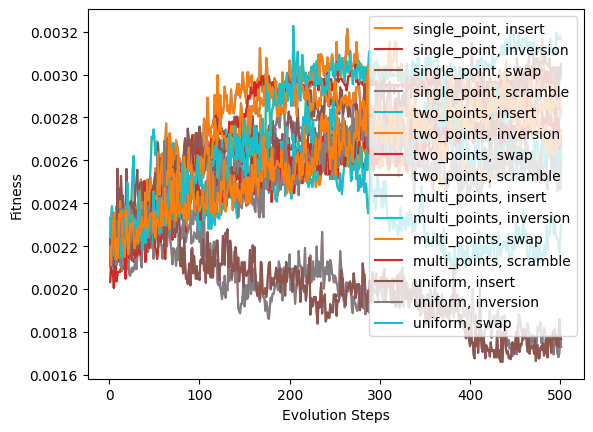

In [10]:
gml_name = 'germany50--D-B-L-N-C-A-N-N.gml'
gml_file_name = 'sample_graph/' + gml_name
adj_matrix = read_graph_from_gml(gml_file_name)
graph = Graph(adj_matrix=adj_matrix)
postmen, demands = read_postmen_and_demands(gml_name)


plts_best3 = []
fitness_result_best3 = {}
for CROSSOVER in crossover_methods:
    plts_best3.append([])
    for MUTATION in mutation_methods:
        gene = Gene(graph=graph, 
                    postmen=postmen, 
                    demands=demands, 
                    population_size=POPULATION_SIZE, 
                    mutation_rate=MUTATION_RATE, 
                    num_generations=NUM_GENERATION, 
                    crossover_method=CROSSOVER, 
                    mutation_operator = MUTATION, 
                    uniform_crossover_rate=UNIFORM_CROSSOVER_RATE,
                    terminal_fitness=TERMINAL_FITNESS)
        gene.create_population()
        gene.evolution()
        fitness_result_best3[CROSSOVER + ", " + MUTATION] = gene.best_each_iter[-1].fitness
        plts_best3[-1].append(gene.print_fitness_evolution(label=CROSSOVER + ", " + MUTATION))


In [11]:
sorted_fitness_result = sorted(fitness_result_best3.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_fitness_result:
    print(key, value)


uniform, swap 0.003165642229667344
two_points, scramble 0.003048205187754924
single_point, inversion 0.0030141665829398175
two_points, swap 0.0029922202274087375
single_point, scramble 0.002909030461704692
multi_points, swap 0.0028937976270859457
two_points, inversion 0.002843072549119155
single_point, swap 0.002738011421419072
uniform, scramble 0.0027379846477289392
multi_points, scramble 0.002674137272379982
multi_points, inversion 0.0026626431170675424
single_point, insert 0.0026228361601678615
uniform, inversion 0.0025992350822472247
two_points, insert 0.00229646235442069
uniform, insert 0.0017658930373360244
multi_points, insert 0.001730802515432989


### Pick out the best three and test out on different graph

In [12]:
best_three_combinations = []
for i in range(3):
    best_three_combinations.append(sorted_fitness_result[i][0].split(", "))

result_dict = {}
for gml_file in os.listdir('sample_graph'):
    adj_matrix = read_graph_from_gml('sample_graph/' + gml_file)
    graph = Graph(adj_matrix=adj_matrix)
    postmen, demands = read_postmen_and_demands(gml_file)

    gml_result = {}
    for CROSSOVER, MUTATION in best_three_combinations:
        gene = Gene(graph=graph, 
                    postmen=postmen, 
                    demands=demands, 
                    population_size=POPULATION_SIZE, 
                    mutation_rate=MUTATION_RATE, 
                    num_generations=NUM_GENERATION, 
                    crossover_method=CROSSOVER, 
                    mutation_operator = MUTATION, 
                    uniform_crossover_rate=UNIFORM_CROSSOVER_RATE,
                    terminal_fitness=TERMINAL_FITNESS)
        gene.create_population()
        gene.evolution()
        combination_result = {}
        combination_result["generation"] = len(gene.best_each_iter)
        combination_result["best_chromosome"] = [chromosome.fitness for chromosome in gene.best_each_iter]
        gml_result[CROSSOVER + ", " + MUTATION] = combination_result
    result_dict[gml_file] = gml_result

uniform, swap: terminated by converge
two_points, scramble: terminated by converge
single_point, inversion: terminated by converge
uniform, swap: terminated by converge
two_points, scramble: terminated by maximum num of generations
single_point, inversion: terminated by maximum num of generations
uniform, swap: terminated by converge
two_points, scramble: terminated by converge
single_point, inversion: terminated by converge
uniform, swap: terminated by maximum num of generations
two_points, scramble: terminated by maximum num of generations
single_point, inversion: terminated by maximum num of generations
uniform, swap: terminated by converge
two_points, scramble: terminated by converge
single_point, inversion: terminated by maximum num of generations
uniform, swap: terminated by converge
two_points, scramble: terminated by converge
single_point, inversion: terminated by converge
uniform, swap: terminated by converge
two_points, scramble: terminated by maximum num of generations
singl

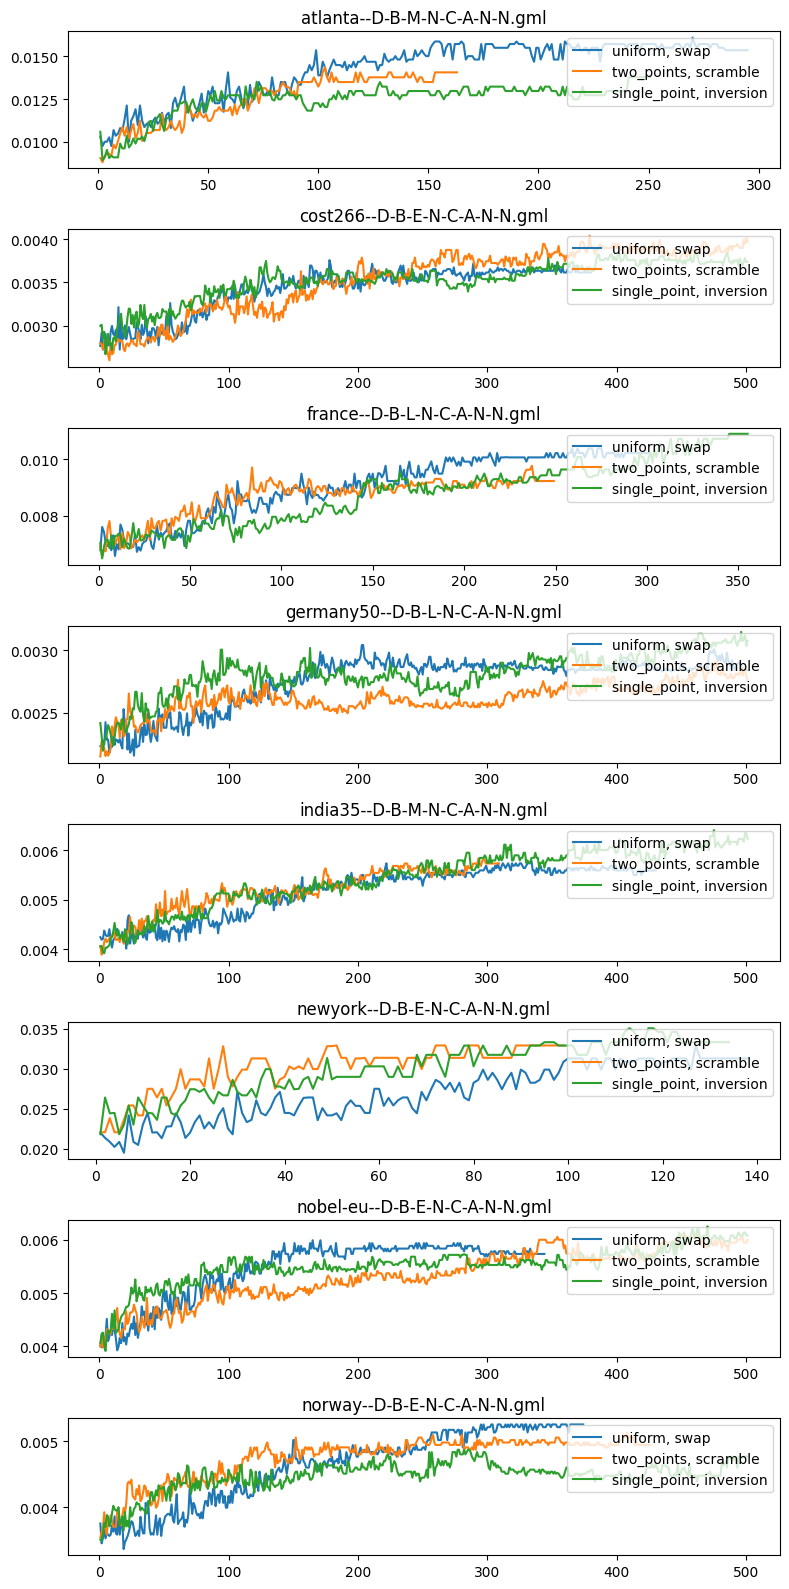

In [13]:
def show_results(result_dict):
    # 创建包含 8 个子图的图表
    fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8, 16))
    for i, (gml_file, gml_results) in enumerate(result_dict.items()):
        for j, (combination, value) in enumerate(gml_results.items()):
            x = list(range(1, value["generation"] + 1))
            y = value["best_chromosome"]
            axes[i].plot(x, y, label=combination)
            axes[i].set_title(gml_file)
            axes[i].legend(loc='upper left')

    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图表
    plt.show()
show_results(result_dict)

In [17]:
#constant parameters for experiment 2, 3, 4
NUM_GENERATION = 500
POPULATION_SIZE = 100
MUTATION_RATE = 0.02
CONVERGE_STEP = 20
UNIFORM_CROSSOVER_RATE = 0.3
TERMINAL_FITNESS = 0.05

CROSSOVER = "uniform"
MUTATION = "swap"



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


uniform, swap: terminated by converge
uniform, swap: terminated by converge
uniform, swap: terminated by maximum num of generations
uniform, swap: terminated by maximum num of generations
uniform, swap: terminated by converge


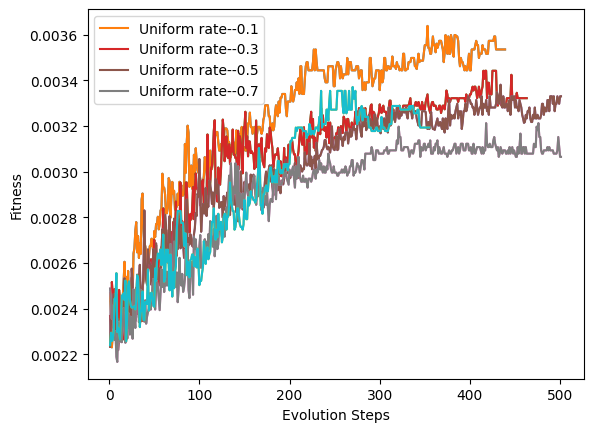

In [22]:
# 3. Test different uniform crossover rates
uniform_crossover_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
gml_name = 'germany50--D-B-L-N-C-A-N-N.gml'
gml_file_name = 'sample_graph/' + gml_name
adj_matrix = read_graph_from_gml(gml_file_name)
graph = Graph(adj_matrix=adj_matrix)
postmen, demands = read_postmen_and_demands(gml_name)

plts_c_rate = []
fitness_result_c_rate = {}
for UNIFORM_CROSSOVER_RATE in uniform_crossover_rates:
        plts_c_rate.append([])
        gene = Gene(graph=graph, 
                    postmen=postmen, 
                    demands=demands, 
                    population_size=POPULATION_SIZE, 
                    mutation_rate=MUTATION_RATE, 
                    num_generations=NUM_GENERATION, 
                    crossover_method="uniform", 
                    mutation_operator = MUTATION, 
                    uniform_crossover_rate=UNIFORM_CROSSOVER_RATE,
                    terminal_fitness=TERMINAL_FITNESS)
        gene.create_population()
        gene.evolution()
        fitness_result_c_rate[CROSSOVER + ", " + MUTATION] = gene.best_each_iter[-1].fitness
        plts_c_rate[-1].append(gene.print_fitness_evolution(label="Uniform rate--" + str(UNIFORM_CROSSOVER_RATE)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


uniform, swap: terminated by converge
uniform, swap: terminated by converge
uniform, swap: terminated by maximum num of generations
uniform, swap: terminated by maximum num of generations
uniform, swap: terminated by maximum num of generations


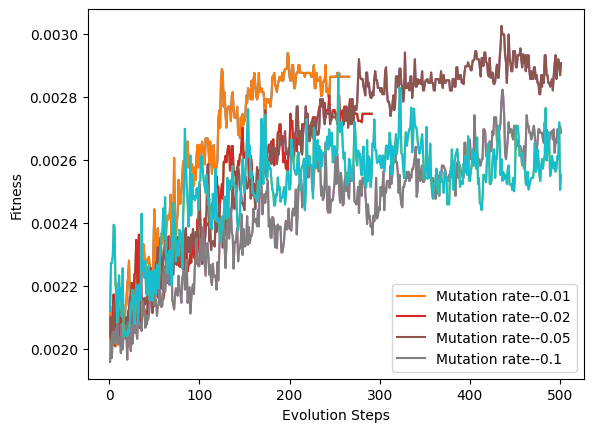

In [24]:
# Test different mutation rates
UNIFORM_CROSSOVER_RATE = 0.1
mutation_rates = [0.01, 0.02, 0.05, 0.1, 0.2]

gml_name = 'germany50--D-B-L-N-C-A-N-N.gml'
gml_file_name = 'sample_graph/' + gml_name
adj_matrix = read_graph_from_gml(gml_file_name)
graph = Graph(adj_matrix=adj_matrix)
postmen, demands = read_postmen_and_demands(gml_name)

plts_m_rate = []
fitness_result_m_rate = {}
for rate in mutation_rates:
        plts_m_rate.append([])
        gene = Gene(graph=graph, 
                    postmen=postmen, 
                    demands=demands, 
                    population_size=POPULATION_SIZE, 
                    mutation_rate=rate, 
                    num_generations=NUM_GENERATION, 
                    crossover_method=CROSSOVER, 
                    mutation_operator = MUTATION, 
                    uniform_crossover_rate=UNIFORM_CROSSOVER_RATE,
                    terminal_fitness=TERMINAL_FITNESS)
        gene.create_population()
        gene.evolution()
        fitness_result_m_rate[CROSSOVER + ", " + MUTATION] = gene.best_each_iter[-1].fitness
        plts_m_rate[-1].append(gene.print_fitness_evolution(label="Mutation rate--" + str(rate)))